In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import importlib
import ridge_regression_task
importlib.reload(ridge_regression_task)
from ridge_regression_task import train_regression_model, train_classification_model
import warnings
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("igloo")
from FLab_process_sequences import get_loop_regions

warnings.filterwarnings('ignore')

DATA_DIR = "benchmarking_data/AbiBench"

# Data processing, get light chain and filter out repeated values

In [ ]:
# fetch light chains for better folding with Ibex
sabdab_df = pd.read_parquet("preprocessed_data/sabdab_2025-05-06-paired.parquet")

aayl_df = pd.read_csv('benchmarking_data/AbiBench/raw/aayl49_51_MITLL_AAlphaBio_Ab_Binding_dataset.csv')
aayl_df['seed'] = aayl_df['POI'].str.split('_').str[0]
aayl_df = aayl_df[aayl_df['seed'].isin(['AAYL49', 'AAYL51'])]
aayl_df = aayl_df[['seed', 'LC']].drop_duplicates()
aayl_df

light_chains_dict = {}
for pdb_code in ["1mlc", "4fqi", "3gbn", "2fjg", "1n8z", "1mhp", "4fqi"]:
    light_chains = sabdab_df[sabdab_df['pdb_code'] == pdb_code]['fv_light'].unique()
    if len(light_chains) != 1:
        print(f"Skipping {pdb_code} because it has {len(light_chains)} light chains")
    light_chain = light_chains[0]
    light_chains_dict[pdb_code] = light_chain

for _, row in aayl_df.iterrows():
    light_chains_dict[row['seed'].lower()] = row['LC']

In [52]:
for k, v in light_chains_dict.items():
    print(f"{k}: {v}")

1mlc: DIELTQSPATLSVTPGDSVSLSCRASQSISNNLHWYQQKSHESPRLLIKYVSQSSSGIPSRFSGSGSGTDFTLSINSVETEDFGMYFCQQSNSWPRTFGGGTKLEIK
4fqi: QSALTQPPAVSGTPGQRVTISCSGSDSNIGRRSVNWYQQFPGTAPKLLIYSNDQRPSVVPDRFSGSKSGTSASLAISGLQSEDEAEYYCAAWDDSLKGAVFGGGTQLTVLG
3gbn: QSVLTQPPSVSAAPGQKVTISCSGSSSNIGNDYVSWYQQLPGTAPKLLIYDNNKRPSGIPDRFSGSKSGTSATLGITGLQTGDEANYYCATWDRRPTAYVVFGGGTKLTVLG
2fjg: DIQMTQSPSSLSASVGDRVTITCRASQDVSTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQSYTTPPTFGQGTKVEIK
1n8z: DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSRSGTDFTLTISSLQPEDFATYYCQQHYTTPPTFGQGTKVEIK
1mhp: dIQLTQSPSSLSASVGDRVTITCSASSSVNHMFWYQQKPGKAPKPWIYLTSNLASGVPSRFSGSGSGTDYTLTISSLQPEDFATYYCQQWSGNPWTFGQGTKVEIK
aayl49: DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKAGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK
aayl51: QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPPQYLLRYKSDSDKQQGSGVPSRFSGSKDASANAGILLISGLQSEDEADYYCMIWHSSAWVFGGGTKLTVL


In [6]:
light_chain_df = pd.DataFrame.from_dict(light_chains_dict, orient='index', columns=['light_chain']).reset_index().rename(columns={'index': 'pdb_id'})
aho_light_chains = get_loop_regions(light_chain_df, heavy_chain_key=None, light_chain_key='light_chain')
aho_light_chains

,pdb_id,light_chain,aho_light,LFW1,L1,LFW2,L2,LFW3,L4,LFW4,L3,LFW5
0,1mlc,DIELTQSPATLSVTPGDSVSLSCRASQSISNNLHWYQQKSHESPRL...,DIELTQSPATLSVTPGDSVSLSCRAS--QSIS------NNLHWYQQ...,DIELTQSPATLSVTPGDSVSLSC,RASQSISNNLH,WYQQKSHESPRLLI,KYVSQSSS,GIPSRFSGS,GSGTDF,TLSINSVETEDFGMYFC,QQSNSWPRT,FGGGTKLEIK
1,4fqi,QSALTQPPAVSGTPGQRVTISCSGSDSNIGRRSVNWYQQFPGTAPK...,QSALTQP-PAVSGTPGQRVTISCSGSD-SNIGR-----RSVNWYQQ...,QSALTQPPAVSGTPGQRVTISC,SGSDSNIGRRSVN,WYQQFPGTAPKLLI,YSNDQRPS,VVPDRFSGS,KSGTSA,SLAISGLQSEDEAEYYC,AAWDDSLKGAV,FGGGTQLTVLG
2,3gbn,QSVLTQPPSVSAAPGQKVTISCSGSSSNIGNDYVSWYQQLPGTAPK...,QSVLTQP-PSVSAAPGQKVTISCSGSS-SNIGN-----DYVSWYQQ...,QSVLTQPPSVSAAPGQKVTISC,SGSSSNIGNDYVS,WYQQLPGTAPKLLI,YDNNKRPS,GIPDRFSGS,KSGTSA,TLGITGLQTGDEANYYC,ATWDRRPTAYVV,FGGGTKLTVLG
3,2fjg,DIQMTQSPSSLSASVGDRVTITCRASQDVSTAVAWYQQKPGKAPKL...,DIQMTQSPSSLSASVGDRVTITCRAS--QDVS------TAVAWYQQ...,DIQMTQSPSSLSASVGDRVTITC,RASQDVSTAVA,WYQQKPGKAPKLLI,YSASFLYS,GVPSRFSGS,GSGTDF,TLTISSLQPEDFATYYC,QQSYTTPPT,FGQGTKVEIK
4,1n8z,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,DIQMTQSPSSLSASVGDRVTITCRAS--QDVN------TAVAWYQQ...,DIQMTQSPSSLSASVGDRVTITC,RASQDVNTAVA,WYQQKPGKAPKLLI,YSASFLYS,GVPSRFSGS,RSGTDF,TLTISSLQPEDFATYYC,QQHYTTPPT,FGQGTKVEIK
5,1mhp,dIQLTQSPSSLSASVGDRVTITCSASSSVNHMFWYQQKPGKAPKPW...,dIQLTQSPSSLSASVGDRVTITCSAS--SSVN-------HMFWYQQ...,dIQLTQSPSSLSASVGDRVTITC,SASSSVNHMF,WYQQKPGKAPKPWI,YLTSNLAS,GVPSRFSGS,GSGTDY,TLTISSLQPEDFATYYC,QQWSGNPWT,FGQGTKVEIK
6,aayl49,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,DVVMTQSPESLAVSLGERATISCKSS--QSVLYESRNKNSVAWYQQ...,DVVMTQSPESLAVSLGERATISC,KSSQSVLYESRNKNSVA,WYQQKAGQPPKLLI,YWASTRES,GVPDRFSGS,GSGTDF,TLTISSLQAEDAAVYYC,QQYHRLPLS,FGGGTKVEIK
7,aayl51,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,QAVLTQP-SSLSASPGASVSLTCTLRS-GINVG----TYRIYWYQQ...,QAVLTQPSSLSASPGASVSLTC,TLRSGINVGTYRIY,WYQQKPGSPPQYLL,RYKSDSDKQQGS,GVPSRFSGS,KDASANAG,ILLISGLQSEDEADYYC,MIWHSSAWV,FGGGTKLTVL


In [ ]:
# mask_out_values = {
#     '3gbn_h1': 7.0,
#     '3gbn_h9': 7.0,
#     '4fqi_h3': 6.0,
#     '4fqi_h1': 7.0,
# } # these values are used to denote non binders? we discard them for regression tasks

# for fname in os.listdir(DATA_DIR):
#     if not fname.endswith("_benchmarking_data.csv"):
#         continue
#     fname_path = os.path.join(DATA_DIR, fname)

#     df = pd.read_csv(fname_path)
#     seed = fname.replace("_benchmarking_data.csv", "")
#     if seed in mask_out_values:
#         df = df[df['binding_score'] != mask_out_values[seed]]
    
#     df['fv_light'] = light_chains_dict[seed.split("_")[0]]

#     df_loops = pd.read_csv(fname_path.replace('.csv', '_loops.csv'))
#     # df_loops = get_loop_regions(df, heavy_chain_key='mut_heavy_chain_seq', light_chain_key=None)
#     df = df[['mut_heavy_chain_seq', 'fv_light']].merge(df_loops, on='mut_heavy_chain_seq', how='left')
#     df.rename(columns={'mut_heavy_chain_seq': 'fv_heavy'}, inplace=True)

#     df.to_csv(fname_path.replace('.csv', '_loops.csv'), index=False)
#     print(f"Processed {fname} (N={len(df)}) and saved loop regions to {fname_path.replace('.csv', '_loops.csv')}")

In [ ]:
# for fname in os.listdir(DATA_DIR):
#     if not fname.endswith("benchmarking_data_loops.csv"):
#         continue
#     fname_path = os.path.join(DATA_DIR, fname)
#     df = pd.read_csv(fname_path)
#     df['ibex_file'] = [f"output_{i}" for i in range(len(df))]
#     df = df.merge(aho_light_chains[['light_chain', 'aho_light']], left_on='fv_light', right_on='light_chain', how='left')
#     df.drop(columns=['light_chain'], inplace=True)
#     df.to_csv(fname_path, index=False)

In [ ]:
for fname in os.listdir(DATA_DIR):
    if not fname.endswith("benchmarking_data_loops.csv"):
        continue

    seed = fname.replace("_benchmarking_data_loops.csv", "")
    parquet_path = f'benchmarking_data/AbiBench/ibex_structures/{seed}_loop_angles.parquet'
    if not os.path.exists(parquet_path):
        print(f"Skipping {fname} because {parquet_path} does not exist")
        continue
    df_loops = pd.read_parquet(parquet_path)
    df_loops['chain'] = df_loops['loop_type'].str[0]
    df_loops['phi'] = df_loops['phi'].apply(lambda x: np.concatenate([np.zeros(1), x, np.zeros(36 - len(x) - 1)]))
    df_loops['psi'] = df_loops['psi'].apply(lambda x: np.concatenate([np.zeros(1), x, np.zeros(36 - len(x) - 1)]))
    df_loops['omega'] = df_loops['omega'].apply(lambda x: np.concatenate([np.zeros(1), x, np.zeros(36 - len(x) - 1)])) # start is cls, end is eos, padding zeros
    df_loops['angles'] = df_loops.apply(lambda row: np.stack([row['phi'], row['psi'], row['omega']], axis=1), axis=1) # shape (36, 3)
    df_loops['angles'] = df_loops['angles'].apply(lambda x: x.tolist())
    agg_loops = (
        df_loops
            .groupby(["ibex_file", "chain"], as_index=False)
            .agg(angles=("angles", lambda s: np.stack(s.to_numpy())))
    )
    agg_loops['angles'] = agg_loops['angles'].apply(lambda x: x.tolist())  # Convert numpy arrays to lists for parquet compatibility

    df = pd.read_csv(os.path.join(DATA_DIR, fname))
    df = df.merge(agg_loops[agg_loops['chain'] == 'H'][['ibex_file', 'angles']], left_on='ibex_file', right_on='ibex_file', how='inner')
    df.to_parquet(os.path.join(DATA_DIR, fname.replace('.csv', '_and_angles.parquet')), index=False)

In [ ]:
import h5py

for seed in ["1mlc", "aayl51", "4fqi_h3", "3gbn_h1", "2fjg", "1n8z", "aayl49", "aayl49_ML", "1mhp", "3gbn_h9", "4fqi_h1"]:
    loop_df = pd.read_csv(os.path.join(DATA_DIR, f"{seed}_benchmarking_data_loops.csv"))
    embeddings = []
    if not os.path.exists(os.path.join(DATA_DIR, f"prostt5/{seed}_embeddings.h5")):
        print(f"Skipping {seed} because {os.path.join(DATA_DIR, f'prostt5/{seed}_embeddings.h5')} does not exist")
        continue
    with h5py.File(os.path.join(DATA_DIR, f"prostt5/{seed}_embeddings.h5"), "r") as f:
        for ibex_file in loop_df['ibex_file'].values:
            embeddings.append(f[f"{ibex_file}_H"][:])
    embeddings = np.array(embeddings)
    print(seed, embeddings.shape)
    np.save(os.path.join(DATA_DIR, f"prostt5/{seed}_embeddings.npy"), embeddings)

4fqi_h1 (63419, 1024)


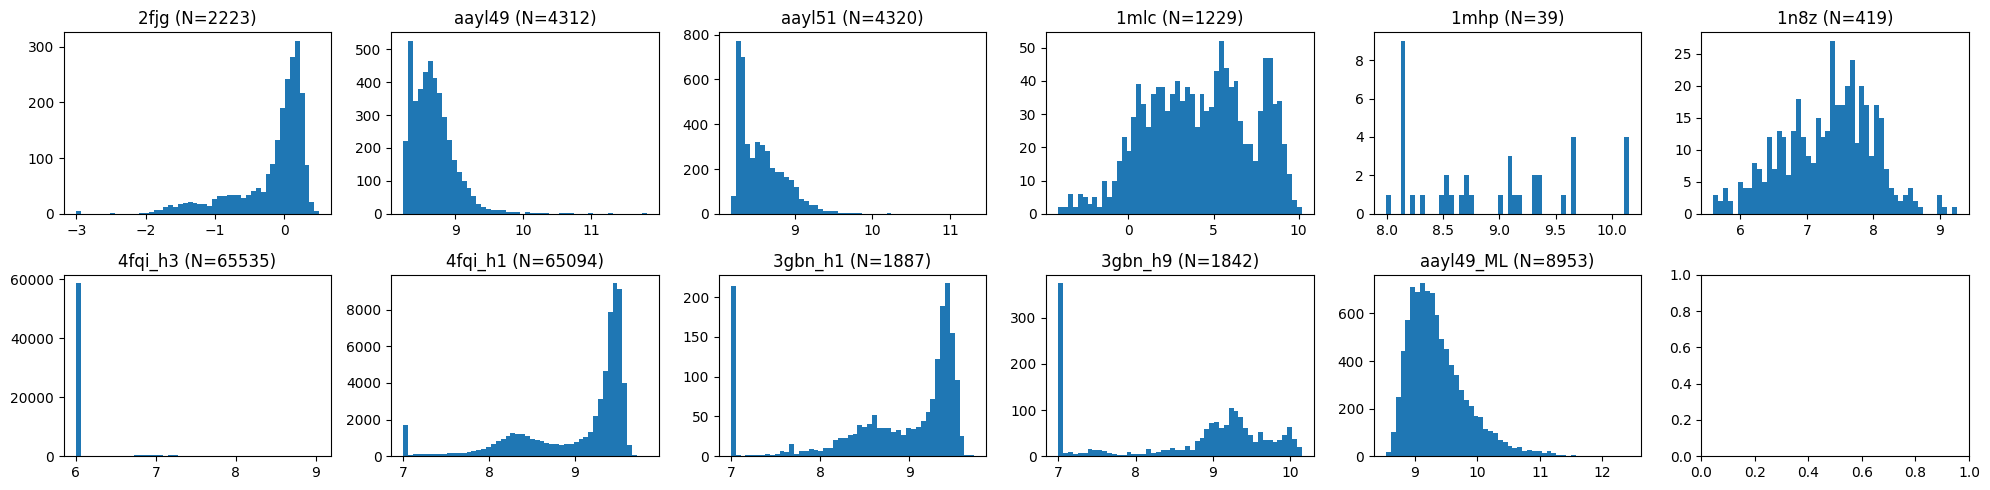

In [60]:
fig, axes = plt.subplots(2,6, figsize=(20, 5))
for i, fname in enumerate(glob(f"{DATA_DIR}/*_loops.csv")):
    basename = os.path.basename(fname).replace("_benchmarking_data_loops.csv", "")
    axes[i // 6, i % 6].set_title(f'{basename} (N={len(pd.read_csv(fname))})')
    df_loops = pd.read_csv(fname)
    axes[i // 6, i % 6].hist(df_loops['binding_score'], bins=50)
plt.tight_layout()
plt.show()

In [24]:
for fname in glob(f"{DATA_DIR}/*_loops.csv"):
    loops_sequences = []
    loops_ids = []
    df_loops = pd.read_csv(fname)
    print(f"################{os.path.basename(fname)}################")
    for loop_type in ['H1', 'H2', 'H3', 'H4', 'HFW1', 'HFW2', 'HFW3', 'HFW4']:
        if loop_type not in df_loops.columns:
            continue
        print(loop_type, df_loops[loop_type].nunique(), end=' ')

        if loop_type in ['H1', 'H2', 'H3', 'H4']:
            loops_sequences.extend(df_loops[loop_type])
            loops_ids.extend([f"{i}_{loop_type}" for i in df_loops.index])
    print()
    loops_df = pd.DataFrame({'loop_id': loops_ids, 'loop_sequence': loops_sequences})
    loops_df.to_csv(fname.replace('_loops.csv', '_loop_cdrcluster_input.csv'), index=False)

################2fjg_benchmarking_data_loops.csv################
H1 248 H2 191 H3 248 H4 153 HFW1 400 HFW2 267 HFW3 229 HFW4 324 
################aayl49_benchmarking_data_loops.csv################
H1 826 H2 529 H3 959 H4 1 HFW1 1 HFW2 1 HFW3 367 HFW4 1 
################aayl51_benchmarking_data_loops.csv################
H1 821 H2 750 H3 972 H4 1 HFW1 1 HFW2 1 HFW3 362 HFW4 1 
################1mlc_benchmarking_data_loops.csv################
H1 226 H2 159 H3 133 H4 95 HFW1 55 HFW2 222 HFW3 209 HFW4 55 
################1mhp_benchmarking_data_loops.csv################
H1 9 H2 15 H3 8 H4 1 HFW1 1 HFW2 1 HFW3 7 HFW4 1 
################1n8z_benchmarking_data_loops.csv################
H1 7 H2 14 H3 416 H4 1 HFW1 1 HFW2 1 HFW3 1 HFW4 1 
################4fqi_h3_benchmarking_data_loops.csv################
H1 8 H2 16 H3 2 H4 16 HFW1 1 HFW2 1 HFW3 2 HFW4 8 
################4fqi_h1_benchmarking_data_loops.csv################
H1 8 H2 16 H3 2 H4 16 HFW1 1 HFW2 1 HFW3 2 HFW4 8 
################3gbn_h1_b

# Run regression

In [27]:
item_id = 'aayl49'
binding_scores_path = f'{DATA_DIR}/{item_id}_benchmarking_data.csv'
binding_scores_df = pd.read_csv(binding_scores_path)

cdrcluster_path = f'{DATA_DIR}/{item_id}_benchmarking_data_cdrcluster_output_v220.parquet'
cdrcluster_df = pd.read_parquet(cdrcluster_path)

esmc_path = f"{DATA_DIR}/ESMC/{item_id}_esmc_embeddings.npy"
esmc_embeddings = np.load(esmc_path)

igbert_embeddings_path = f"{DATA_DIR}/IgBert/continue_finetune_igbert_v16/{item_id}_benchmarking_data_igbert.npy"
igbert_embeddings = np.load(igbert_embeddings_path)

plm_embeddings_path = f'{DATA_DIR}/IgBert/baseline/{item_id}_benchmarking_data_igbert.npy'
plm_embeddings = np.load(plm_embeddings_path)

no_igloo_embeddings_path = f'{DATA_DIR}/IgBert/no_igloo_v14/{item_id}_benchmarking_data_igbert.npy'
no_igloo_embeddings = np.load(no_igloo_embeddings_path)

with_igloo_embeddings_path = f'{DATA_DIR}/IgBert/with_igloo_v52/{item_id}_benchmarking_data_igbert.npy'
with_igloo_embeddings = np.load(with_igloo_embeddings_path)

y_full = binding_scores_df['binding_score'].values

mask_out_values = {
    '3gbn_h1': 7.0,
    '3gbn_h9': 7.0,
}

if item_id in mask_out_values:
    mask = binding_scores_df['binding_score'] != mask_out_values[item_id]
    print(f"Masking out (N={np.sum(~mask)}) binding scores equal to {mask_out_values[item_id]}")
    y_full = y_full[mask]
    plm_embeddings = plm_embeddings[mask]
    igbert_embeddings = igbert_embeddings[mask]
    no_igloo_embeddings = no_igloo_embeddings[mask]
    with_igloo_embeddings = with_igloo_embeddings[mask]
    esmc_embeddings = esmc_embeddings[mask]
else:
    mask = np.ones(len(y_full), dtype=bool)
    
y_full = StandardScaler().fit_transform(y_full.reshape(-1, 1)).flatten()

print(f"X_full shape: {plm_embeddings.shape} {igbert_embeddings.shape} {no_igloo_embeddings.shape} {with_igloo_embeddings.shape} {esmc_embeddings.shape}, y_full shape: {y_full.shape}")

X_full shape: (4312, 1024) (4312, 1024) (4312, 1024) (4312, 1024) (4312, 960), y_full shape: (4312,)


In [28]:
if cdrcluster_df['id'].str.contains('HFW').sum() > 0:
    print("Removing HFW loops from cdrcluster_df")
    # Remove HFW loops from the cdrcluster_df
    cdrcluster_df = cdrcluster_df[~cdrcluster_df['id'].str.contains('HFW')]
cdrcluster_df['sequence_id'] = cdrcluster_df['id'].str.split('_').str[0].astype(int)
cdrcluster_df['loop_type'] = cdrcluster_df['id'].str.split('_').str[1]
loop_tokens = cdrcluster_df.groupby('sequence_id').agg(
    encoded=('encoded', lambda x: np.array(list(x)).flatten()),
    quantized=('quantized', lambda x: np.array(list(x)).flatten()),
    quantized_indices=('quantized_indices', list)).sort_index()

X_encoded_only = np.stack(loop_tokens['encoded'].values)[mask]
X_quantized_full = np.concatenate((plm_embeddings,np.stack(loop_tokens['quantized'].values)[mask]), axis=1)
X_full = np.concatenate((plm_embeddings, X_encoded_only), axis=1)
print(f"X_full shape: {X_full.shape}")

X_full shape: (4312, 1536)


In [14]:
res_without_cdrcluster = train_regression_model(esmc_embeddings, y_full, pca_components=plm_embeddings.shape[1], verbose=False)

Outer CV Folds: 100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


--- Cross-Validation Complete ---
Average Test Loss across 10 folds: 0.4960, std: 0.1230
Average R2 Score across 10 folds: 0.4906, std: 0.0640
Average Test Pearson Correlation across 10 folds: 0.7171, std: 0.0442
Average Test Spearman Correlation across 10 folds: 0.6733, std: 0.0697


In [29]:
res_without_cdrcluster = train_regression_model(igbert_embeddings, y_full, pca_components=plm_embeddings.shape[1], verbose=False)

Outer CV Folds: 100%|██████████| 10/10 [09:51<00:00, 59.18s/it]


--- Cross-Validation Complete ---
Average Test Loss across 10 folds: 0.6512, std: 0.1247
Average R2 Score across 10 folds: 0.3438, std: 0.0387
Average Test Pearson Correlation across 10 folds: 0.5977, std: 0.0253
Average Test Spearman Correlation across 10 folds: 0.6281, std: 0.0296


In [33]:
res_without_cdrcluster = train_regression_model(plm_embeddings, y_full, pca_components=plm_embeddings.shape[1], verbose=False)

Outer CV Folds: 100%|██████████| 10/10 [16:14<00:00, 97.47s/it] 


--- Cross-Validation Complete ---
Average Test Loss across 10 folds: 0.6669, std: 0.1311
Average R2 Score across 10 folds: 0.3289, std: 0.0367
Average Test Pearson Correlation across 10 folds: 0.5804, std: 0.0280
Average Test Spearman Correlation across 10 folds: 0.6112, std: 0.0320


In [30]:
res_without_cdrcluster = train_regression_model(with_igloo_embeddings, y_full, pca_components=plm_embeddings.shape[1], verbose=False)

Outer CV Folds: 100%|██████████| 10/10 [11:40<00:00, 70.06s/it]


--- Cross-Validation Complete ---
Average Test Loss across 10 folds: 0.6561, std: 0.1270
Average R2 Score across 10 folds: 0.3391, std: 0.0399
Average Test Pearson Correlation across 10 folds: 0.5938, std: 0.0252
Average Test Spearman Correlation across 10 folds: 0.6287, std: 0.0343


In [32]:
res_with_cdrcluster = train_regression_model(no_igloo_embeddings, y_full, pca_components=no_igloo_embeddings.shape[1], verbose=False)

Outer CV Folds: 100%|██████████| 10/10 [14:56<00:00, 89.64s/it]


--- Cross-Validation Complete ---
Average Test Loss across 10 folds: 0.6521, std: 0.1357
Average R2 Score across 10 folds: 0.3441, std: 0.0466
Average Test Pearson Correlation across 10 folds: 0.5981, std: 0.0297
Average Test Spearman Correlation across 10 folds: 0.6308, std: 0.0320


In [104]:
res_with_cdrcluster = train_regression_model(X_full, y_full, pca_components=X_full.shape[1], verbose=False)

Outer CV Folds:  40%|████      | 4/10 [01:20<02:01, 20.21s/it]


KeyboardInterrupt: 

In [110]:
res_with_cdrcluster = train_regression_model(X_encoded_only, y_full, pca_components=X_full.shape[1], verbose=False)


--- Cross-Validation Complete ---
Average Test Loss across 10 folds: 0.1713, std: 0.0155
Average R2 Score across 10 folds: 0.8273, std: 0.0197
Average Test Pearson Correlation across 10 folds: 0.9105, std: 0.0102
Average Test Spearman Correlation across 10 folds: 0.9532, std: 0.0069
